# Monocyte downstram analyses

In [4]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
# from scanpy.plotting._tools.scatterplots import plot_scatter
import seaborn as sns

In [8]:
# set a working directory
wdir = '/rd2/user/xiacr/sle/output_file/SCENIC/mono_dc_pySCENIC/'
os.chdir( wdir )

# path to loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = './pyscenic_out_mono_dc_filter_harmony.loom'

In [6]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=150)

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.7.2
sinfo       0.3.4
-----
MulticoreTSNE       NA
PIL                 8.4.0
attr                21.4.0
backcall            0.2.0
boltons             NA
cached_property     1.5.2
cffi                1.14.6
cloudpickle         2.0.0
ctxcore             0.1.1
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.0
dateutil            2.8.2
decorator           4.4.2
entrypoints         0.3
frozendict          2.1.3
fsspec    

## Extract relevant data from the integrated loom file(not recommanded)

In [9]:
# scenic output
lf = lp.connect( f_final_loom, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

KeyboardInterrupt: 

In [ ]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

In [ ]:
# cell annotations from the loom column attributes:
cellAnnot = pd.concat(
    [
        pd.DataFrame( lf.ca.Celltype_Garnett, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.ClusterID, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Louvain_clusters_Scanpy, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Percent_mito, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nGene, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nUMI, index=lf.ca.CellID ),
    ],
    axis=1
)
cellAnnot.columns = [
 'Celltype_Garnett',
 'ClusterID',
 'Louvain_clusters_Scanpy',
 'Percent_mito',
 'nGene',
 'nUMI']

In [ ]:
# capture embeddings:
dr = [
    pd.DataFrame( lf.ca.Embedding, index=lf.ca.CellID )
]
dr_names = [
    meta['embeddings'][0]['name'].replace(" ","_")
]

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

for i in range( len(drx.columns) ):
    dr.append( pd.concat( [ drx.iloc[:,i], dry.iloc[:,i] ], sort=False, axis=1, join='outer' ))
    dr_names.append( meta['embeddings'][i+1]['name'].replace(" ","_").replace('/','-') )

# rename columns:
for i,x in enumerate( dr ):
    x.columns = ['X','Y']

In [ ]:
lf.close()

## Alternately, we can load this data into a scanpy.AnnData object

In [44]:
adata = sc.read_loom(f_final_loom, validate=True)

# drop the embeddings and extra attributes from the obs object
# adata.obs.drop( ['Embedding','Embeddings_X','Embeddings_Y','RegulonsAUC'], axis=1, inplace=True )

ValueError: Row attribute 'Regulons' dtype [('AHR(+)', '<i8'), ('ARID3A(+)', '<i8'), ('ARID5B(+)', '<i8'), ('ARNTL(+)', '<i8'), ('ARNTL2(+)', '<i8'), ('ATF1(+)', '<i8'), ('ATF3(+)', '<i8'), ('ATF5(+)', '<i8'), ('ATF6(+)', '<i8'), ('ATF6B(+)', '<i8'), ('ATF7(+)', '<i8'), ('BACH1(+)', '<i8'), ('BACH2(+)', '<i8'), ('BATF(+)', '<i8'), ('BCL11A(+)', '<i8'), ('BCL6(+)', '<i8'), ('BHLHE40(+)', '<i8'), ('BRF2(+)', '<i8'), ('CEBPB(+)', '<i8'), ('CEBPD(+)', '<i8'), ('CEBPE(+)', '<i8'), ('CEBPZ(+)', '<i8'), ('CLOCK(+)', '<i8'), ('CREB1(+)', '<i8'), ('CREB3(+)', '<i8'), ('CREB3L2(+)', '<i8'), ('CREB3L4(+)', '<i8'), ('CREBL2(+)', '<i8'), ('CREM(+)', '<i8'), ('CTCF(+)', '<i8'), ('CUX1(+)', '<i8'), ('DBP(+)', '<i8'), ('E2F1(+)', '<i8'), ('E2F3(+)', '<i8'), ('E2F4(+)', '<i8'), ('E2F6(+)', '<i8'), ('E4F1(+)', '<i8'), ('EGR1(+)', '<i8'), ('EGR2(+)', '<i8'), ('EGR3(+)', '<i8'), ('EHF(+)', '<i8'), ('ELF1(+)', '<i8'), ('ELF2(+)', '<i8'), ('ELF3(+)', '<i8'), ('ELF4(+)', '<i8'), ('ELK1(+)', '<i8'), ('ELK3(+)', '<i8'), ('ELK4(+)', '<i8'), ('EOMES(+)', '<i8'), ('ERF(+)', '<i8'), ('ERG(+)', '<i8'), ('ESR2(+)', '<i8'), ('ESRRA(+)', '<i8'), ('ETS1(+)', '<i8'), ('ETS2(+)', '<i8'), ('ETV2(+)', '<i8'), ('ETV3(+)', '<i8'), ('ETV3L(+)', '<i8'), ('ETV5(+)', '<i8'), ('ETV6(+)', '<i8'), ('ETV7(+)', '<i8'), ('FLI1(+)', '<i8'), ('FOS(+)', '<i8'), ('FOSB(+)', '<i8'), ('FOSL1(+)', '<i8'), ('FOSL2(+)', '<i8'), ('FOXD4L1(+)', '<i8'), ('FOXJ1(+)', '<i8'), ('FOXJ2(+)', '<i8'), ('FOXJ3(+)', '<i8'), ('FOXK1(+)', '<i8'), ('FOXO1(+)', '<i8'), ('FOXO3(+)', '<i8'), ('FOXO4(+)', '<i8'), ('GABPA(+)', '<i8'), ('GATA1(+)', '<i8'), ('GATA2(+)', '<i8'), ('GLI1(+)', '<i8'), ('GRHL1(+)', '<i8'), ('GTF2B(+)', '<i8'), ('HES1(+)', '<i8'), ('HESX1(+)', '<i8'), ('HIC1(+)', '<i8'), ('HIVEP1(+)', '<i8'), ('HIVEP2(+)', '<i8'), ('HLF(+)', '<i8'), ('HMGA2(+)', '<i8'), ('HOXA10(+)', '<i8'), ('HOXA7(+)', '<i8'), ('HOXA9(+)', '<i8'), ('HOXB2(+)', '<i8'), ('IKZF1(+)', '<i8'), ('IRF1(+)', '<i8'), ('IRF2(+)', '<i8'), ('IRF3(+)', '<i8'), ('IRF4(+)', '<i8'), ('IRF7(+)', '<i8'), ('IRF8(+)', '<i8'), ('IRF9(+)', '<i8'), ('ISL2(+)', '<i8'), ('JDP2(+)', '<i8'), ('JUN(+)', '<i8'), ('JUNB(+)', '<i8'), ('JUND(+)', '<i8'), ('KDM5B(+)', '<i8'), ('KLF1(+)', '<i8'), ('KLF12(+)', '<i8'), ('KLF13(+)', '<i8'), ('KLF16(+)', '<i8'), ('KLF2(+)', '<i8'), ('KLF3(+)', '<i8'), ('KLF4(+)', '<i8'), ('KLF6(+)', '<i8'), ('KLF8(+)', '<i8'), ('KLF9(+)', '<i8'), ('LBX2(+)', '<i8'), ('LCORL(+)', '<i8'), ('LEF1(+)', '<i8'), ('MAFB(+)', '<i8'), ('MAFF(+)', '<i8'), ('MAFG(+)', '<i8'), ('MAFK(+)', '<i8'), ('MAX(+)', '<i8'), ('MAZ(+)', '<i8'), ('MEF2A(+)', '<i8'), ('MEF2B(+)', '<i8'), ('MEF2D(+)', '<i8'), ('MEIS1(+)', '<i8'), ('MGA(+)', '<i8'), ('MITF(+)', '<i8'), ('MSC(+)', '<i8'), ('MXD3(+)', '<i8'), ('MXI1(+)', '<i8'), ('MYB(+)', '<i8'), ('MYBL1(+)', '<i8'), ('MYBL2(+)', '<i8'), ('MYC(+)', '<i8'), ('MYCN(+)', '<i8'), ('NFATC1(+)', '<i8'), ('NFATC3(+)', '<i8'), ('NFE2(+)', '<i8'), ('NFE2L1(+)', '<i8'), ('NFE2L2(+)', '<i8'), ('NFE2L3(+)', '<i8'), ('NFIA(+)', '<i8'), ('NFIL3(+)', '<i8'), ('NFIX(+)', '<i8'), ('NFKB1(+)', '<i8'), ('NFKB2(+)', '<i8'), ('NFYA(+)', '<i8'), ('NFYB(+)', '<i8'), ('NFYC(+)', '<i8'), ('NHLH1(+)', '<i8'), ('NKX2-3(+)', '<i8'), ('NR1H3(+)', '<i8'), ('NR2C2(+)', '<i8'), ('NR2F6(+)', '<i8'), ('NR3C1(+)', '<i8'), ('NR4A1(+)', '<i8'), ('NR6A1(+)', '<i8'), ('NRF1(+)', '<i8'), ('PATZ1(+)', '<i8'), ('PAX5(+)', '<i8'), ('PAX8(+)', '<i8'), ('PBX1(+)', '<i8'), ('PBX3(+)', '<i8'), ('PKNOX1(+)', '<i8'), ('PLAGL2(+)', '<i8'), ('POU2F1(+)', '<i8'), ('PPARD(+)', '<i8'), ('PPARG(+)', '<i8'), ('PRDM1(+)', '<i8'), ('RARG(+)', '<i8'), ('REL(+)', '<i8'), ('RELA(+)', '<i8'), ('RELB(+)', '<i8'), ('REST(+)', '<i8'), ('RFX1(+)', '<i8'), ('RFX2(+)', '<i8'), ('RFX5(+)', '<i8'), ('RORA(+)', '<i8'), ('RUNX2(+)', '<i8'), ('RXRA(+)', '<i8'), ('RXRB(+)', '<i8'), ('SETDB1(+)', '<i8'), ('SHOX2(+)', '<i8'), ('SMAD4(+)', '<i8'), ('SMAD5(+)', '<i8'), ('SNAI1(+)', '<i8'), ('SOX4(+)', '<i8'), ('SOX5(+)', '<i8'), ('SOX6(+)', '<i8'), ('SP1(+)', '<i8'), ('SP2(+)', '<i8'), ('SP3(+)', '<i8'), ('SP4(+)', '<i8'), ('SPI1(+)', '<i8'), ('SPIB(+)', '<i8'), ('SPIC(+)', '<i8'), ('SREBF1(+)', '<i8'), ('SREBF2(+)', '<i8'), ('SRF(+)', '<i8'), ('STAT1(+)', '<i8'), ('STAT2(+)', '<i8'), ('STAT3(+)', '<i8'), ('STAT4(+)', '<i8'), ('STAT5A(+)', '<i8'), ('STAT5B(+)', '<i8'), ('TAL1(+)', '<i8'), ('TBP(+)', '<i8'), ('TBX19(+)', '<i8'), ('TBX21(+)', '<i8'), ('TBX3(+)', '<i8'), ('TBX6(+)', '<i8'), ('TCF12(+)', '<i8'), ('TCF3(+)', '<i8'), ('TCF4(+)', '<i8'), ('TCF7(+)', '<i8'), ('TCF7L2(+)', '<i8'), ('TEF(+)', '<i8'), ('TFAP4(+)', '<i8'), ('TFE3(+)', '<i8'), ('TFEC(+)', '<i8'), ('TGIF2(+)', '<i8'), ('THAP1(+)', '<i8'), ('THAP11(+)', '<i8'), ('THRB(+)', '<i8'), ('TP53(+)', '<i8'), ('TRPS1(+)', '<i8'), ('USF1(+)', '<i8'), ('USF2(+)', '<i8'), ('XBP1(+)', '<i8'), ('YBX1(+)', '<i8'), ('YY1(+)', '<i8'), ('ZBTB14(+)', '<i8'), ('ZBTB16(+)', '<i8'), ('ZBTB17(+)', '<i8'), ('ZBTB18(+)', '<i8'), ('ZBTB33(+)', '<i8'), ('ZBTB7A(+)', '<i8'), ('ZBTB7B(+)', '<i8'), ('ZFP64(+)', '<i8'), ('ZNF143(+)', '<i8'), ('ZNF229(+)', '<i8'), ('ZNF230(+)', '<i8'), ('ZNF233(+)', '<i8'), ('ZNF274(+)', '<i8'), ('ZNF282(+)', '<i8'), ('ZNF319(+)', '<i8'), ('ZNF354C(+)', '<i8'), ('ZNF362(+)', '<i8'), ('ZNF382(+)', '<i8'), ('ZNF384(+)', '<i8'), ('ZNF460(+)', '<i8'), ('ZNF467(+)', '<i8'), ('ZNF471(+)', '<i8'), ('ZNF554(+)', '<i8'), ('ZNF572(+)', '<i8'), ('ZNF573(+)', '<i8'), ('ZNF585A(+)', '<i8'), ('ZNF589(+)', '<i8'), ('ZNF596(+)', '<i8'), ('ZNF611(+)', '<i8'), ('ZNF629(+)', '<i8'), ('ZNF674(+)', '<i8'), ('ZNF682(+)', '<i8'), ('ZNF727(+)', '<i8'), ('ZNF76(+)', '<i8'), ('ZNF768(+)', '<i8'), ('ZNF770(+)', '<i8'), ('ZNF774(+)', '<i8'), ('ZNF91(+)', '<i8'), ('ZSCAN20(+)', '<i8'), ('ZSCAN5A(+)', '<i8')] is not allowed
Column attribute 'RegulonsAUC' dtype [('AHR(+)', '<f8'), ('ARID3A(+)', '<f8'), ('ARID5B(+)', '<f8'), ('ARNTL(+)', '<f8'), ('ARNTL2(+)', '<f8'), ('ATF1(+)', '<f8'), ('ATF3(+)', '<f8'), ('ATF5(+)', '<f8'), ('ATF6(+)', '<f8'), ('ATF6B(+)', '<f8'), ('ATF7(+)', '<f8'), ('BACH1(+)', '<f8'), ('BACH2(+)', '<f8'), ('BATF(+)', '<f8'), ('BCL11A(+)', '<f8'), ('BCL6(+)', '<f8'), ('BHLHE40(+)', '<f8'), ('BRF2(+)', '<f8'), ('CEBPB(+)', '<f8'), ('CEBPD(+)', '<f8'), ('CEBPE(+)', '<f8'), ('CEBPZ(+)', '<f8'), ('CLOCK(+)', '<f8'), ('CREB1(+)', '<f8'), ('CREB3(+)', '<f8'), ('CREB3L2(+)', '<f8'), ('CREB3L4(+)', '<f8'), ('CREBL2(+)', '<f8'), ('CREM(+)', '<f8'), ('CTCF(+)', '<f8'), ('CUX1(+)', '<f8'), ('DBP(+)', '<f8'), ('E2F1(+)', '<f8'), ('E2F3(+)', '<f8'), ('E2F4(+)', '<f8'), ('E2F6(+)', '<f8'), ('E4F1(+)', '<f8'), ('EGR1(+)', '<f8'), ('EGR2(+)', '<f8'), ('EGR3(+)', '<f8'), ('EHF(+)', '<f8'), ('ELF1(+)', '<f8'), ('ELF2(+)', '<f8'), ('ELF3(+)', '<f8'), ('ELF4(+)', '<f8'), ('ELK1(+)', '<f8'), ('ELK3(+)', '<f8'), ('ELK4(+)', '<f8'), ('EOMES(+)', '<f8'), ('ERF(+)', '<f8'), ('ERG(+)', '<f8'), ('ESR2(+)', '<f8'), ('ESRRA(+)', '<f8'), ('ETS1(+)', '<f8'), ('ETS2(+)', '<f8'), ('ETV2(+)', '<f8'), ('ETV3(+)', '<f8'), ('ETV3L(+)', '<f8'), ('ETV5(+)', '<f8'), ('ETV6(+)', '<f8'), ('ETV7(+)', '<f8'), ('FLI1(+)', '<f8'), ('FOS(+)', '<f8'), ('FOSB(+)', '<f8'), ('FOSL1(+)', '<f8'), ('FOSL2(+)', '<f8'), ('FOXD4L1(+)', '<f8'), ('FOXJ1(+)', '<f8'), ('FOXJ2(+)', '<f8'), ('FOXJ3(+)', '<f8'), ('FOXK1(+)', '<f8'), ('FOXO1(+)', '<f8'), ('FOXO3(+)', '<f8'), ('FOXO4(+)', '<f8'), ('GABPA(+)', '<f8'), ('GATA1(+)', '<f8'), ('GATA2(+)', '<f8'), ('GLI1(+)', '<f8'), ('GRHL1(+)', '<f8'), ('GTF2B(+)', '<f8'), ('HES1(+)', '<f8'), ('HESX1(+)', '<f8'), ('HIC1(+)', '<f8'), ('HIVEP1(+)', '<f8'), ('HIVEP2(+)', '<f8'), ('HLF(+)', '<f8'), ('HMGA2(+)', '<f8'), ('HOXA10(+)', '<f8'), ('HOXA7(+)', '<f8'), ('HOXA9(+)', '<f8'), ('HOXB2(+)', '<f8'), ('IKZF1(+)', '<f8'), ('IRF1(+)', '<f8'), ('IRF2(+)', '<f8'), ('IRF3(+)', '<f8'), ('IRF4(+)', '<f8'), ('IRF7(+)', '<f8'), ('IRF8(+)', '<f8'), ('IRF9(+)', '<f8'), ('ISL2(+)', '<f8'), ('JDP2(+)', '<f8'), ('JUN(+)', '<f8'), ('JUNB(+)', '<f8'), ('JUND(+)', '<f8'), ('KDM5B(+)', '<f8'), ('KLF1(+)', '<f8'), ('KLF12(+)', '<f8'), ('KLF13(+)', '<f8'), ('KLF16(+)', '<f8'), ('KLF2(+)', '<f8'), ('KLF3(+)', '<f8'), ('KLF4(+)', '<f8'), ('KLF6(+)', '<f8'), ('KLF8(+)', '<f8'), ('KLF9(+)', '<f8'), ('LBX2(+)', '<f8'), ('LCORL(+)', '<f8'), ('LEF1(+)', '<f8'), ('MAFB(+)', '<f8'), ('MAFF(+)', '<f8'), ('MAFG(+)', '<f8'), ('MAFK(+)', '<f8'), ('MAX(+)', '<f8'), ('MAZ(+)', '<f8'), ('MEF2A(+)', '<f8'), ('MEF2B(+)', '<f8'), ('MEF2D(+)', '<f8'), ('MEIS1(+)', '<f8'), ('MGA(+)', '<f8'), ('MITF(+)', '<f8'), ('MSC(+)', '<f8'), ('MXD3(+)', '<f8'), ('MXI1(+)', '<f8'), ('MYB(+)', '<f8'), ('MYBL1(+)', '<f8'), ('MYBL2(+)', '<f8'), ('MYC(+)', '<f8'), ('MYCN(+)', '<f8'), ('NFATC1(+)', '<f8'), ('NFATC3(+)', '<f8'), ('NFE2(+)', '<f8'), ('NFE2L1(+)', '<f8'), ('NFE2L2(+)', '<f8'), ('NFE2L3(+)', '<f8'), ('NFIA(+)', '<f8'), ('NFIL3(+)', '<f8'), ('NFIX(+)', '<f8'), ('NFKB1(+)', '<f8'), ('NFKB2(+)', '<f8'), ('NFYA(+)', '<f8'), ('NFYB(+)', '<f8'), ('NFYC(+)', '<f8'), ('NHLH1(+)', '<f8'), ('NKX2-3(+)', '<f8'), ('NR1H3(+)', '<f8'), ('NR2C2(+)', '<f8'), ('NR2F6(+)', '<f8'), ('NR3C1(+)', '<f8'), ('NR4A1(+)', '<f8'), ('NR6A1(+)', '<f8'), ('NRF1(+)', '<f8'), ('PATZ1(+)', '<f8'), ('PAX5(+)', '<f8'), ('PAX8(+)', '<f8'), ('PBX1(+)', '<f8'), ('PBX3(+)', '<f8'), ('PKNOX1(+)', '<f8'), ('PLAGL2(+)', '<f8'), ('POU2F1(+)', '<f8'), ('PPARD(+)', '<f8'), ('PPARG(+)', '<f8'), ('PRDM1(+)', '<f8'), ('RARG(+)', '<f8'), ('REL(+)', '<f8'), ('RELA(+)', '<f8'), ('RELB(+)', '<f8'), ('REST(+)', '<f8'), ('RFX1(+)', '<f8'), ('RFX2(+)', '<f8'), ('RFX5(+)', '<f8'), ('RORA(+)', '<f8'), ('RUNX2(+)', '<f8'), ('RXRA(+)', '<f8'), ('RXRB(+)', '<f8'), ('SETDB1(+)', '<f8'), ('SHOX2(+)', '<f8'), ('SMAD4(+)', '<f8'), ('SMAD5(+)', '<f8'), ('SNAI1(+)', '<f8'), ('SOX4(+)', '<f8'), ('SOX5(+)', '<f8'), ('SOX6(+)', '<f8'), ('SP1(+)', '<f8'), ('SP2(+)', '<f8'), ('SP3(+)', '<f8'), ('SP4(+)', '<f8'), ('SPI1(+)', '<f8'), ('SPIB(+)', '<f8'), ('SPIC(+)', '<f8'), ('SREBF1(+)', '<f8'), ('SREBF2(+)', '<f8'), ('SRF(+)', '<f8'), ('STAT1(+)', '<f8'), ('STAT2(+)', '<f8'), ('STAT3(+)', '<f8'), ('STAT4(+)', '<f8'), ('STAT5A(+)', '<f8'), ('STAT5B(+)', '<f8'), ('TAL1(+)', '<f8'), ('TBP(+)', '<f8'), ('TBX19(+)', '<f8'), ('TBX21(+)', '<f8'), ('TBX3(+)', '<f8'), ('TBX6(+)', '<f8'), ('TCF12(+)', '<f8'), ('TCF3(+)', '<f8'), ('TCF4(+)', '<f8'), ('TCF7(+)', '<f8'), ('TCF7L2(+)', '<f8'), ('TEF(+)', '<f8'), ('TFAP4(+)', '<f8'), ('TFE3(+)', '<f8'), ('TFEC(+)', '<f8'), ('TGIF2(+)', '<f8'), ('THAP1(+)', '<f8'), ('THAP11(+)', '<f8'), ('THRB(+)', '<f8'), ('TP53(+)', '<f8'), ('TRPS1(+)', '<f8'), ('USF1(+)', '<f8'), ('USF2(+)', '<f8'), ('XBP1(+)', '<f8'), ('YBX1(+)', '<f8'), ('YY1(+)', '<f8'), ('ZBTB14(+)', '<f8'), ('ZBTB16(+)', '<f8'), ('ZBTB17(+)', '<f8'), ('ZBTB18(+)', '<f8'), ('ZBTB33(+)', '<f8'), ('ZBTB7A(+)', '<f8'), ('ZBTB7B(+)', '<f8'), ('ZFP64(+)', '<f8'), ('ZNF143(+)', '<f8'), ('ZNF229(+)', '<f8'), ('ZNF230(+)', '<f8'), ('ZNF233(+)', '<f8'), ('ZNF274(+)', '<f8'), ('ZNF282(+)', '<f8'), ('ZNF319(+)', '<f8'), ('ZNF354C(+)', '<f8'), ('ZNF362(+)', '<f8'), ('ZNF382(+)', '<f8'), ('ZNF384(+)', '<f8'), ('ZNF460(+)', '<f8'), ('ZNF467(+)', '<f8'), ('ZNF471(+)', '<f8'), ('ZNF554(+)', '<f8'), ('ZNF572(+)', '<f8'), ('ZNF573(+)', '<f8'), ('ZNF585A(+)', '<f8'), ('ZNF589(+)', '<f8'), ('ZNF596(+)', '<f8'), ('ZNF611(+)', '<f8'), ('ZNF629(+)', '<f8'), ('ZNF674(+)', '<f8'), ('ZNF682(+)', '<f8'), ('ZNF727(+)', '<f8'), ('ZNF76(+)', '<f8'), ('ZNF768(+)', '<f8'), ('ZNF770(+)', '<f8'), ('ZNF774(+)', '<f8'), ('ZNF91(+)', '<f8'), ('ZSCAN20(+)', '<f8'), ('ZSCAN5A(+)', '<f8')] is not allowed
For help, see http://linnarssonlab.org/loompy/format/
./pyscenic_out_mono_dc_filter_harmony.loom does not appead to be a valid Loom file according to Loom spec version '3.0.0'

In [43]:
adata.obs['RegulonsAUC']

In [23]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/home/xiacr/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/xiacr/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/xiacr/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

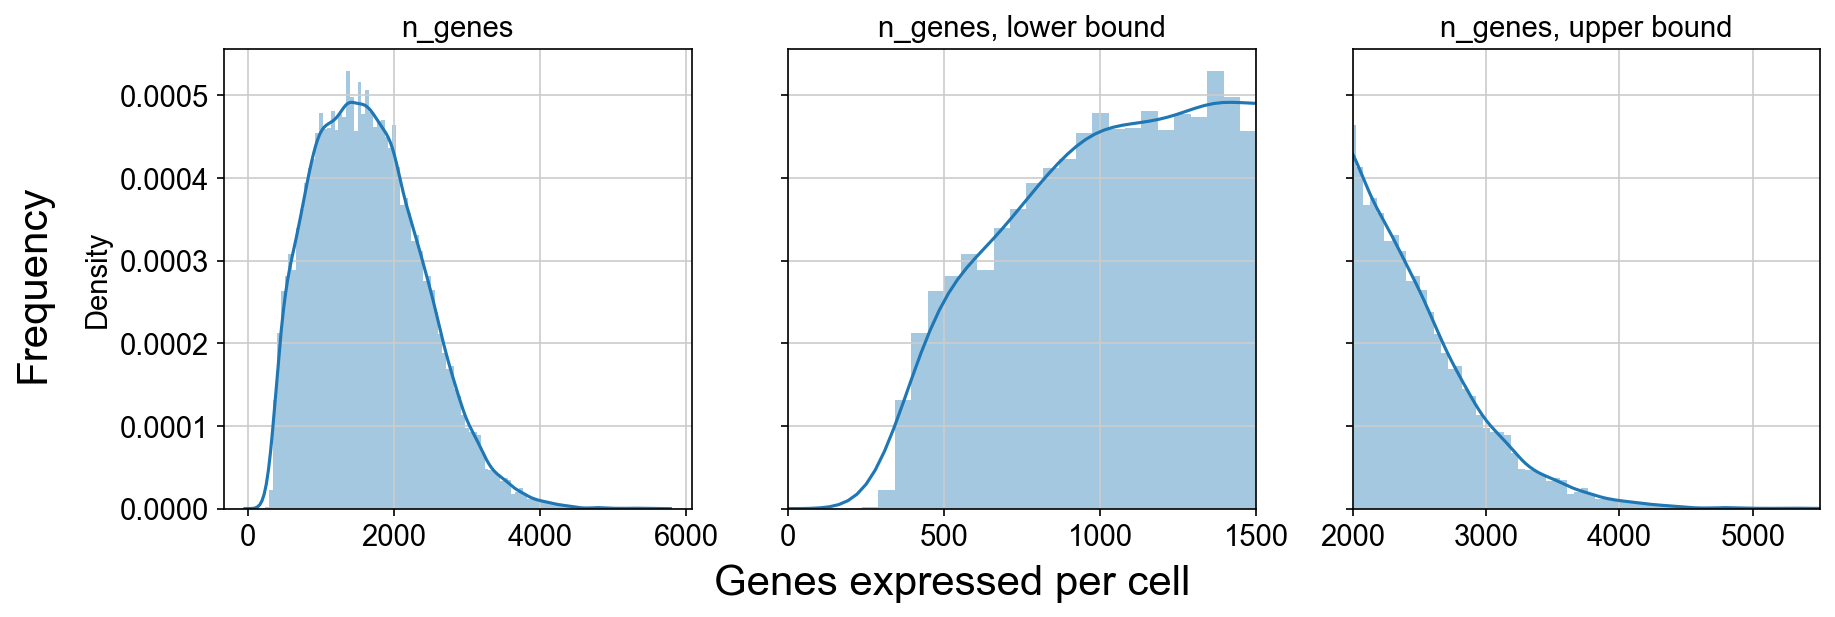

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['n_genes']
x_lowerbound = 1500
x_upperbound = 2000
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, adata.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

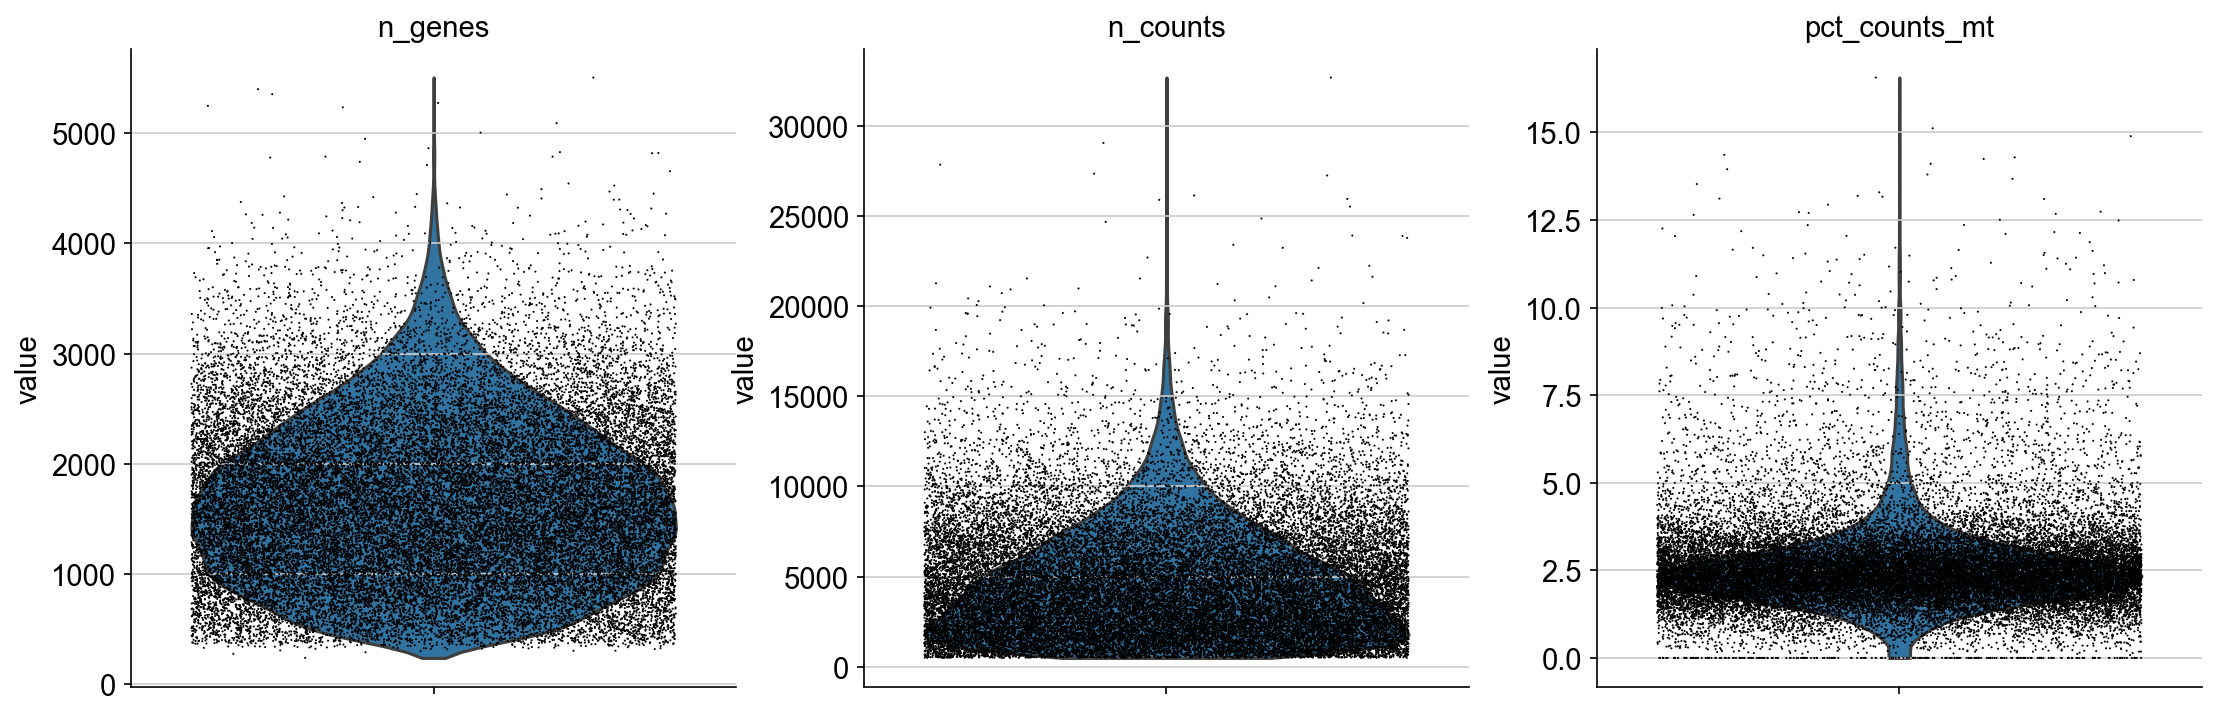

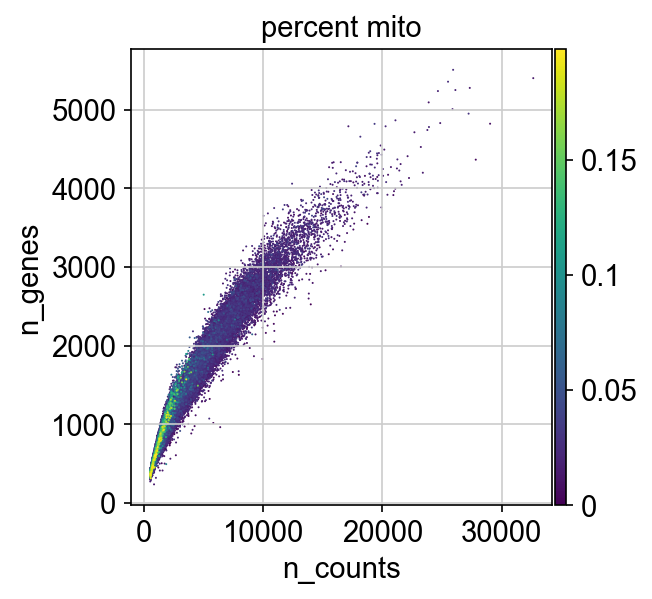

In [25]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'pct_counts_mt'],
    jitter=0.4, multi_panel=True )
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

In [26]:
sc.pp.highly_variable_genes(adata, flavor ='seurat_v3',n_top_genes =2500) # must specify n_top_genes when using seurat v3
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.raw = adata # You can get back an AnnData of the object in .raw by calling .raw.to_adata().
adata = adata[:, adata.var.highly_variable]

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) # long time
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.6)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
/home/xiacr/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
regressing out ['total_counts', 'pct_counts_mt']
    finished (0:04:43)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:11)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:37)
computing UMAP

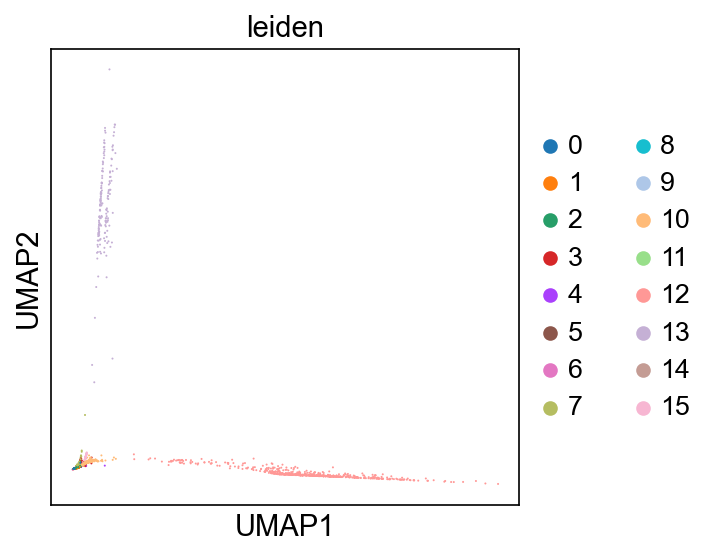

In [28]:
sc.pl.umap(adata, color=['leiden'] )